In [1]:
import json
import timeit, time
from functools import partial
import matplotlib.pyplot as pl
import seaborn as sns
import pandas as pd
from pathlib import Path
import math

# Not Your Grandma's Review Analyzer

## COSC 320 - Milestone 3

### Team Members

Quinn Marshall, Archita Gattani, and Connor Doman

## Algorithm

### Importing Data

Our algorithm requires us to read from a JSON file. We load that here.

In [2]:
DATA_FILE_FOLDER = '../data/raw/'
DATA_FILE_NAME = 'sports_and_outdoors_reviews'
DATA_FILE_TYPE = '.json'
DATA_FILE_PATH = Path(DATA_FILE_FOLDER + DATA_FILE_NAME + DATA_FILE_TYPE)

def get_reviews_from_sports_data():    
    sports_data = []
    start = time.time()
    with open(Path(DATA_FILE_FOLDER + DATA_FILE_NAME + '_million' + DATA_FILE_TYPE), 'r') as f:
        sports_data = json.load(f)
    end = time.time()

    print(f"Got {len(sports_data)} reviews in {end - start:.2f}s")

    total_review_size = 0
    review_text = []
    for i, r in enumerate(sports_data):
        if 'reviewText' in r:
            total_review_size += len(r['reviewText'])
            review_text.append(r['reviewText'])
    average_review_length = math.ceil(total_review_size / len(review_text))
    print(f"Average review length: {average_review_length} characters")

    return (review_text, average_review_length, total_review_size)

### Algorithm 1

The following is an implementation of our first algorithm. We start by determining a dictionary of translations. 

In [23]:

REPLACEMENT_DICTIONARY = {
    "the": "THE",
    "hello": "hi",
    "fun": "TERRIBLE",
    "how": "what",
    "are": "COSC322",
    "you": "me"
}


class TrieNode:
    def __init__(self):
        self.children = {}
        self.end_of_word = False
# end of class TrieNode

class Trie:
    def __init__(self):
        self.root = TrieNode()
        self.operations = 0

    def insert(self, word):
        node = self.root
        for char in word:
            if char not in node.children:
                self.operations += 1
                node.children[char] = TrieNode()
            node = node.children[char]
        node.end_of_word = True

    def replace(self, T, t=REPLACEMENT_DICTIONARY):
        words = T.split(" ")
        for i, word in enumerate(words):
            node = self.root
            for j, char in enumerate(word):
                if char not in node.children:
                    break
                node = node.children[char]
                if node.end_of_word:
                    words[i] = t.get(word, word)
                    self.operations += 1
                    break
        return " ".join(words), self.operations
# end of class Trie


# Algorithm 2
def create_trie_from_text(text):
    t = Trie()
    for word in text.split(" "):
        t.insert(word)
    return t

### Asymptotic Analysis

The following code pulls the review data from the JSON file and loads the main body of each review into a list.

In [4]:
REVIEWS, AVERAGE_REVIEW_LENGTH, TOTAL_REVIEW_SIZE = get_reviews_from_sports_data() # 999999 reviews

Got 999999 reviews in 2.94s
Average review length: 246 characters



Below is a function that will time our algorithm in increasing steps of `nInc`, each timing of length `nTests`.

In order to capture the value returned by our function after each test, we must first modify the `timeit` library's test template:

In [5]:
def calculate_time_complexity(fn, n_min, n_max, n_inc, samples, arguments=[]):
    """
    Run timer and plot time complexity
    """
    if n_min > n_max:
        raise ValueError("nMin must be less than nMax")

    if len(samples) == 0:
        raise ValueError("samples must be a list of strings")

    if n_max < len(samples):
        samples = samples[:n_max]

    print(f"Testing '{fn.__name__}' from input {n_min} to {n_max} in steps of {n_inc}...")
    
    start = time.time() # start counting total time
    x = []
    y = []
    for i in range(n_min, n_max, n_inc):
        args = arguments.copy()
        N = i
        args.insert(0, N)
        # test_N_timer = timeit.Timer(partial(fn, *args)) # our algorithm is called here

        # t, ops = test_N_timer.timeit(number=n_tests) # retrieve time and number of characters
        ops = partial(fn, *args)()

        x.append(N)
        y.append(ops)
        
    end = time.time() # stop counting total time
    print(f"{fn.__name__} took {end - start:.2f}s") # print total time

    df = pd.DataFrame({'x': x, 'y': y})
    return df

In [6]:
def plot(df, title, x_label, y_label):
    """
    Plot time complexity
    """
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x="x", y="y")
    pl.title(title)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.show()

In [21]:
def test_algorithm_2(N):
    """
    Combines all the reviews in the sample into one mega string to be passed to replace_with_new_word
    """
    start = time.time() # start counting total time

    reviews_array_temp = REVIEWS[:N]
    mega_string = " ".join(reviews_array_temp)
    # text, operations = replace_with_new_word(mega_string) # our algorithm
    text, operations = create_trie_from_text(mega_string).replace(mega_string)

    end = time.time() # stop counting total time
    print(f"test_algorithm_2(N={N}, samples={len(reviews_array_temp)}, length={len(mega_string)}): {end - start:.2f}s") # print total time
    return operations

### Testing

To save time, we will only test the first 1000 reviews. We will also load the script only once.

### Comparison

We estimated our algorithm would run in `O(nm)` time, how does it compare to the literal function `f(n, m)`?

In [8]:
def fn_linear(n):
    """
    O(n) function
    """
    ops = 0
    for i in range(n):
        ops += 1
    return n


def fn_squared(n):
    """
    O(n^2) function
    """
    ops = 0
    for i in range(n):
        for j in range(n):
            x = i*j
            ops += 1
    return ops


def fn_multiple(n, m):
    """
    O(nm) function
    """
    ops = 0
    for i in range(n):
        for j in range(m):
            x = i*j
            ops += 1
    return ops

In [9]:
def plot(df, title, x_label, y_label):
    """
    Plot time complexity
    """
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x="operations", y="value", hue="variable")
    pl.title(title)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.legend(loc='upper left', title='Algorithm')
    pl.ticklabel_format(style='plain', axis='y')
    pl.show()

Testing 'fn_multiple' from input 1 to 1000 in steps of 10...
fn_multiple took 0.43s
Testing 'fn_squared' from input 1 to 1000 in steps of 10...
fn_squared took 1.16s
Testing 'test_algorithm_2' from input 1 to 1000 in steps of 10...
test_algorithm_2(N=1, samples=1, length=754): 0.00s
test_algorithm_2(N=11, samples=11, length=2862): 0.00s
test_algorithm_2(N=21, samples=21, length=7245): 0.00s
test_algorithm_2(N=31, samples=31, length=10774): 0.00s
test_algorithm_2(N=41, samples=41, length=13792): 0.00s
test_algorithm_2(N=51, samples=51, length=16621): 0.00s
test_algorithm_2(N=61, samples=61, length=20260): 0.01s
test_algorithm_2(N=71, samples=71, length=22729): 0.01s
test_algorithm_2(N=81, samples=81, length=25907): 0.01s
test_algorithm_2(N=91, samples=91, length=28383): 0.01s
test_algorithm_2(N=101, samples=101, length=32803): 0.25s
test_algorithm_2(N=111, samples=111, length=38099): 0.01s
test_algorithm_2(N=121, samples=121, length=40477): 0.01s
test_algorithm_2(N=131, samples=131, len

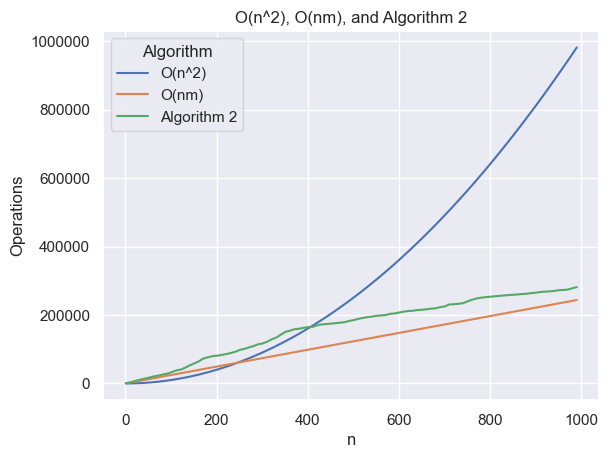

In [24]:
n = 1000 # number of words in a review
m = AVERAGE_REVIEW_LENGTH # approximate number of characters in a word
increments = 10

fn_multi = calculate_time_complexity(fn_multiple, 1, n, increments, samples=REVIEWS, arguments=[m])
fn_square = calculate_time_complexity(fn_squared, 1, n, increments, samples=REVIEWS)
fn_algorithm = calculate_time_complexity(test_algorithm_2, 1, n, increments, samples=REVIEWS)

df = pd.DataFrame({'operations': fn_algorithm['x'], 'O(n^2)': fn_square['y'], 'O(nm)': fn_multi['y'], 'Algorithm 2': fn_algorithm['y']})

final_df = pd.melt(df, ['operations'])

plot(final_df, f"O(n^2), O(nm), and Algorithm 2", "n", "Operations")